In [ ]:
# INTEL CORPORATION CONFIDENTIAL AND PROPRIETARY
# 
# Copyright © 2018-2021 Intel Corporation.
# 
# This software and the related documents are Intel copyrighted
# materials, and your use of them is governed by the express 
# license under which they were provided to you (License). Unless
# the License provides otherwise, you may not use, modify, copy, 
# publish, distribute, disclose or transmit  this software or the
# related documents without Intel's prior written permission.
# 
# This software and the related documents are provided as is, with
# no express or implied warranties, other than those that are 
# expressly stated in the License.

In [1]:
%config IPCompleter.greedy=True
import matplotlib.pyplot as plt
import numpy as np
import nxsdk.api.n2a as nx

# Neuronal homeostasis
Neuronal homeostasis can be used to adapt the excitability of a neuron to different levels of input stimulus intensity. 
The Loihi neuron model supports a built-in homeostasis rule which we call *range homeostasis* whereby the membrane threshold $v^{(thMant)}$ is updated according to the following rule:

$$
v^{(thMant)}(t) = v^{(thMant)}(t-T^{(epoch)}) + \beta \cdot \left( \max \left(a(t)-a^{(max)}, 0 \right) + \min \left(a(t)-a^{(min)}, 0 \right) \right)
$$
Similarly to synaptic plasticity, the homeostasis rule is evalutated at the end of an epoch $T^{(epoch)}$. $a^{(min)}$ and $a^{(max)}$ define an activity range. As long as the activity of a compartment $a$ remains within that range the membrane threshold does not change. If $a^{(max)}$ is exceed, the threshold increases, while the threshold decreases when the activity drops below $a^{(min)}$. $\beta$ is a gain parameter which controls how much deviation outside of the activity range impact the membrance threshold.

Besides this built-in homeostasis rule, other mechanisms to adapt the excitability of a compartment can be implemented by constructing multi-compartment neurons which allows us to design more complex neural behaviors.
As an example, we demonstrate the implementation of another homeostatic rule which we call 'exponential-decay' homeostasis which is governed by the following dynamics:

$$
\begin{eqnarray}
v^{(th)} & = & v^{(th,0)} + \Delta v^{(th)} \\
\Delta v^{(th)} & = & \Delta v^{(th)} \cdot (1-\delta^{(th)}) + \beta \cdot s(t)
\end{eqnarray}
$$
Here the minimum membrane threshold is given by the baseline value $v^{(th,0)}$. Whenever the compartment spikes ($s(t)=1$), the adaptive part of the threshold $\Delta v^{(th)}$ increases by and amount $\beta$ and then decays exponentially with a time constant $\tau^{(th)}$.
We show below how such an effective homeostatic behavior can be implemented with Loihi's multi-compartment capabilities.

An illustration of the network used in this tutorial is shown below.

![Homeostasis](figures/jupyter_homeostasis.png)

## Activity range homeostasis
In this first tutorial, we demonstrate the configuration and dynamics of the built-in 'range homeostasis' mechanism to adapt the membrane threshold of a compartment as a function of its firing activity.

We set the target activity range to $[a^{(min)}, a^{(max)}]=[20, 80]$. Within this activity range, the membrane threshold remains static. Above/below the threshold increases/decreases and thus the firing activity decreases/increases.

To drive the spiking activity of the compartment, we inject 4 successive spike trains with different spike frequencies.

### Generate input spikes with varying intensity in 4 intervals

In [2]:
def genSpikeTimes():
    spikeTimes = np.arange(1, 300, 25)
    spikeTimes = np.append(spikeTimes, np.arange(301, 800, 10))
    spikeTimes = np.append(spikeTimes, np.arange(801, 1300, 20))
    spikeTimes = np.append(spikeTimes, np.arange(1301, 1800, 35))
    
    return spikeTimes.tolist()

### Setup network with compartment subject to range homeostasis

In [3]:
def setupRangeHomeostasisNetwork():
    net = nx.NxNet()
    
    # Create compartment
    cxProto = nx.CompartmentPrototype(
        enableHomeostasis=1,
        vThMant=1000,
        compartmentCurrentDecay=int(1 / 10 * 2 ** 12),
        compartmentVoltageDecay=int(1 / 16 * 2 ** 12),
        activityTimeConstant=16,
        activityImpulse=40,
        minActivity=20,
        maxActivity=80,
        homeostasisGain=1,
        tEpoch=2)
    cx = net.createCompartment(cxProto)
    
    # Create and connect spike generator to compartment
    spikeGenerator = net.createSpikeGenProcess(numPorts=1)
    spikeGenerator.addSpikes(0, genSpikeTimes())
    connProto = nx.ConnectionPrototype(weight=255, 
                                       signMode=nx.SYNAPSE_SIGN_MODE.EXCITATORY)
    spikeGenerator.connect(cx, connProto)

    # Define probes for current, activity and membrane threshold
    probes = {}
    probes['uProbe'] = cx.probe(nx.ProbeParameter.COMPARTMENT_CURRENT)[0]
    probes['vProbe'] = cx.probe(nx.ProbeParameter.COMPARTMENT_VOLTAGE)[0]
    probes['sProbe'] = cx.probe(nx.ProbeParameter.SPIKE)[0]
    probes['aProbe'] = cx.probe(nx.ProbeParameter.SOMA_STATE_ACTIVITY)[0]
    probes['vThProbe'] = cx.probe(nx.ProbeParameter.SOMA_THRESHOLD_VOLTAGE)[0]

    return net, probes

### Run network

In [4]:
net, probes = setupRangeHomeostasisNetwork()

net.run(2000)
net.disconnect()

INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 134.134.68.80:18861
INFO:DRV:  N2Driver: Running...
INFO:DRV:      Compiling synapses... Done (0.00s)
INFO:DRV:      Processing probes... Done (0.00s)
INFO:DRV:      Writing modified registers... Done (0.01s)
INFO:DRV:      Initializing... Done (0.01s)
INFO:DRV:      Preparing input... Done (0.02s)
INFO:DRV:      Executing... Done (0.19s)
INFO:DRV:      Processing timeSeries... Done (0.06s)
INFO:DRV:  N2Driver: Finished (0.30s)


### Plot and analyze results

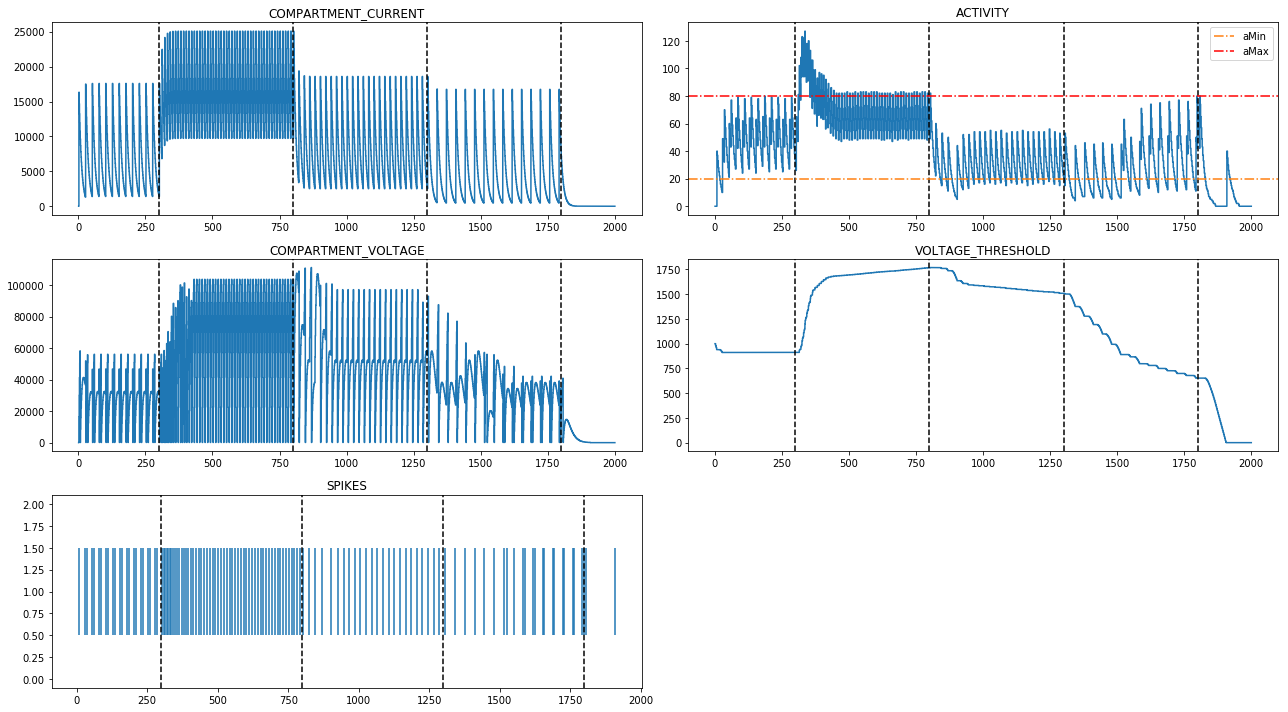

In [5]:
def drawIntervalSeperators(intervalBoundaries):
    for t in intervalBoundaries:
        plt.axvline(x=t, color='k', linestyle='--')

# Plot the results
fig = plt.figure(1, figsize=(18,10))
intervalBoundaries = [300, 800, 1300, 1800]

plt.subplot(3, 2, 1)
probes['uProbe'].plot()
plt.title('COMPARTMENT_CURRENT')
drawIntervalSeperators(intervalBoundaries)

plt.subplot(3, 2, 3)
probes['vProbe'].plot()
plt.title('COMPARTMENT_VOLTAGE')
drawIntervalSeperators(intervalBoundaries)

plt.subplot(3, 2, 5)
probes['sProbe'].plot()
plt.title('SPIKES')
drawIntervalSeperators(intervalBoundaries)

plt.subplot(3, 2, 2)
probes['aProbe'].plot()
plt.title('ACTIVITY')
drawIntervalSeperators(intervalBoundaries)
plt.axhline(y=20, color='tab:orange', linestyle='-.', label="aMin")
plt.axhline(y=80, color='r', linestyle='-.', label="aMax")
plt.legend()

plt.subplot(3, 2, 4)
probes['vThProbe'].plot()
plt.title('VOLTAGE_THRESHOLD')
drawIntervalSeperators(intervalBoundaries)

plt.tight_layout()
plt.show()

# The COMPARTMENT_CURRENT diagram shows that we inject input spikes at 4 different frequencies. As a result, the ACTIVITY
# stays within then activity range first but then rises above and drops below the activity range. Whenever the ACTIVITY
# leaves the predefined activity range, VOLTAGE_THRESHOLD either increases or decreases.

## Exponential decay homeostasis
In the second tutorial, we demonstrate the configuration and dynamics of the 'exponential-decay' homeostasis mechanism which is realized with the help of an auxiliary compartment.

In order to realize this homeostatic behavior, we create a multi-compartment neuron. The main compartment, integrates external input just as the compartment in the first tutorial. In addition, we connect this main compartment to an auxiliary child compartment with an inhibitory weight. Whenever the main compartment spikes, the membrane potential of the auxiliary compartment decreases and decays exponentially back to zero with a slow time constant on the scale of the desired threshold decay.
We then add the membrane potential of the auxiliary child compartment to the main compartment.
Although the actual firing threshold of the main compartment does not change the effective difference between threshold and membrane potential increases for every spike of the main compartment and decays with the time constant of the threshold decay.

To demonstrate this mechanism we inject the same stimulus as in the previous tutorial.

In [6]:
def setupExponentialDecayHomeostasisNetwork():
    net = nx.NxNet()
    
    # Define neuron model parameters
    baselineVth = 0.01
    scale = 10**7         # Scale factor from high level to finite precision model
    beta = 0.9            # High level model threshold impulse
    tauAux = 400          # Decay time constant of threshold decay and thus auxiliary compartment
    tauMain = 20          # Decay time constant of main compartment
    
    # Create auxiliary compartment
    auxiliaryCompartmentPrototype = nx.CompartmentPrototype(
        vThMant=10000,
        compartmentCurrentDecay=2**12-1,
        compartmentVoltageDecay=int(1/tauAux * 2**12)
    )

    # Create main compartment
    mainCompartmentPrototype = nx.CompartmentPrototype(
        vThMant=int((baselineVth*scale)/(2**6)),
        compartmentCurrentDecay=2**12-1,
        compartmentVoltageDecay=int(1/tauMain * 2**12)
    )

    mainCompartmentPrototype.addDendrite(auxiliaryCompartmentPrototype,
                                         nx.COMPARTMENT_JOIN_OPERATION.ADD)

    np = nx.NeuronPrototype(mainCompartmentPrototype)
    n = net.createNeuron(np)

    # Compute effective inhibitory weight from main to auxiliary compartment from threshold impulse and time constants
    weightAux = -beta*(1/(tauAux * tauMain) - 1/(tauAux**2))*scale
    # Decompose auxiliary weight into mantissa and exponent
    wgtAuxMant = int(weightAux / (2 ** 6))
    wgtAuxExp = 0
    for i in range(0, 8):
        if wgtAuxMant % 2 == 0:
            wgtAuxExp += 1
            wgtAuxMant = int(wgtAuxMant/2)
        else:
            break
    
    # Connect main to auxiliary compartment
    mainToAuxillaryConnectionProto = nx.ConnectionPrototype(
        weight=wgtAuxMant, 
        weightExponent=wgtAuxExp,
        signMode=nx.SYNAPSE_SIGN_MODE.INHIBITORY, 
        compressionMode=nx.SYNAPSE_COMPRESSION_MODE.DENSE)
    n.connect(n.dendrites[0], prototype=mainToAuxillaryConnectionProto)


    # Create spike generator
    spikeGenerator = net.createSpikeGenProcess(numPorts=1)
    
    # Connect spike generator to main compartment
    spikeConnProto = nx.ConnectionPrototype(
        weight=98, 
        weightExponent=4,
        signMode=nx.SYNAPSE_SIGN_MODE.EXCITATORY)
    spikeGenerator.connect(n.soma, prototype=spikeConnProto)
    
    # Define input stimulus
    spikeGenerator.addSpikes(0, genSpikeTimes())


    # Define probes for main compartment's current, voltage and spikes
    mainProbes = {}
    cx = n.soma
    mainProbes['uProbe'] = cx.probe(nx.ProbeParameter.COMPARTMENT_CURRENT)[0]
    mainProbes['vProbe'] = cx.probe(nx.ProbeParameter.COMPARTMENT_VOLTAGE)[0]
    mainProbes['sProbe'] = cx.probe(nx.ProbeParameter.SPIKE)[0]
    
    # Define probes for auxiliary compartment's current, voltage and spikes
    auxProbes = {}
    cx = n.dendrites[0]
    auxProbes['uProbe'] = cx.probe(nx.ProbeParameter.COMPARTMENT_CURRENT)[0]
    auxProbes['vProbe'] = cx.probe(nx.ProbeParameter.COMPARTMENT_VOLTAGE)[0]
    auxProbes['sProbe'] = cx.probe(nx.ProbeParameter.SPIKE)[0]
    
    return net, mainProbes, auxProbes

### Run network

In [7]:
net, mainProbes, auxProbes = setupExponentialDecayHomeostasisNetwork()

net.run(2000)
net.disconnect()

INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 134.134.68.80:18861
INFO:DRV:  N2Driver: Running...
INFO:DRV:      Compiling synapses... Done (0.00s)
INFO:DRV:      Processing probes... Done (0.00s)
INFO:DRV:      Writing modified registers... Done (0.01s)
INFO:DRV:      Initializing... Done (0.01s)
INFO:DRV:      Preparing input... Done (0.02s)
INFO:DRV:      Executing... Done (0.20s)
INFO:DRV:      Processing timeSeries... Done (0.06s)
INFO:DRV:  N2Driver: Finished (0.30s)


## Plot and analyze results

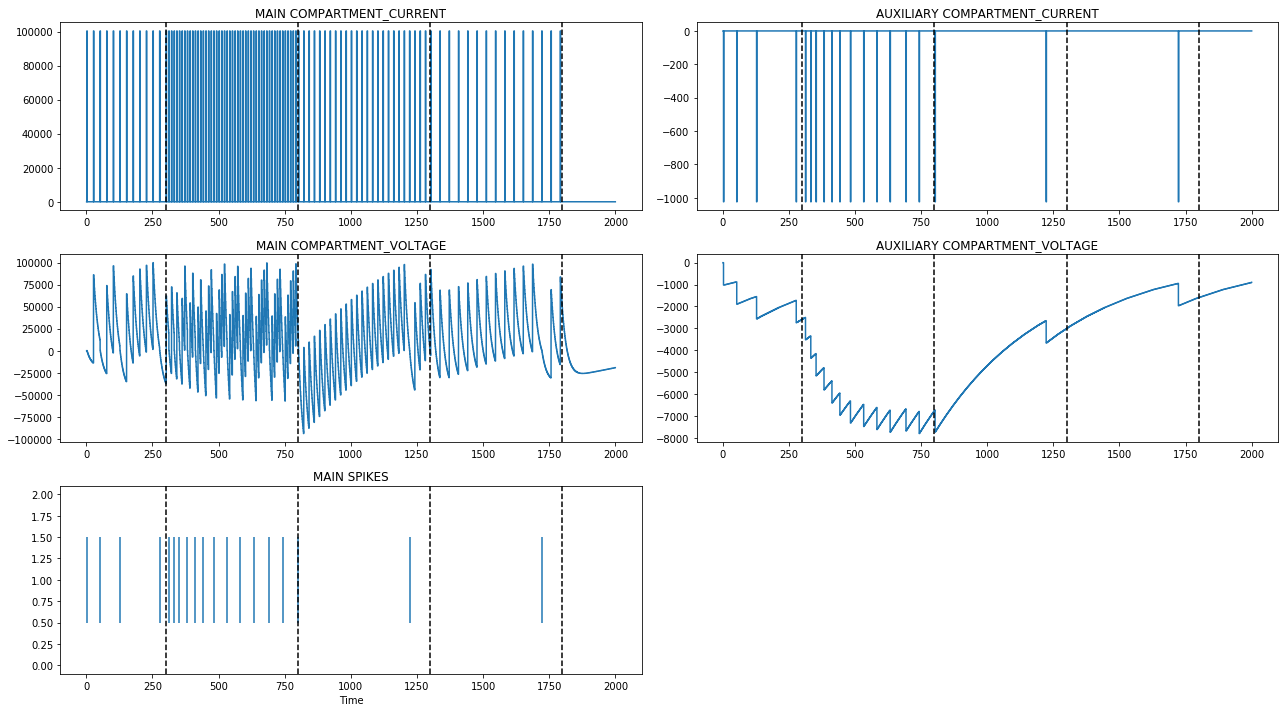

In [8]:
plt.figure(2, figsize=(18,10))

# Main compartment
ax0 = plt.subplot(3, 2, 1)
mainProbes['uProbe'].plot()
plt.title('MAIN COMPARTMENT_CURRENT')
drawIntervalSeperators(intervalBoundaries)

plt.subplot(3, 2, 3)
mainProbes['vProbe'].plot()
plt.title('MAIN COMPARTMENT_VOLTAGE')
drawIntervalSeperators(intervalBoundaries)

ax5 = plt.subplot(3, 2, 5)
mainProbes['sProbe'].plot()
ax5.set_xlim(ax0.get_xlim())
plt.title('MAIN SPIKES')
plt.xlabel('Time')
drawIntervalSeperators(intervalBoundaries)

# Auxiliary compartment
plt.subplot(3, 2, 2)
auxProbes['uProbe'].plot()
plt.title('AUXILIARY COMPARTMENT_CURRENT')
drawIntervalSeperators(intervalBoundaries)

plt.subplot(3, 2, 4)
auxProbes['vProbe'].plot()
plt.title('AUXILIARY COMPARTMENT_VOLTAGE')
drawIntervalSeperators(intervalBoundaries)

plt.tight_layout()
plt.show()

# We stimulate the MAIN neuron with the same input spike train as before. As the MAIN compartment starts spiking, the
# COMPARTMENT_VOLTAGE of the AUXILIARY compartment drops. Because the MAIN compartment integrates the input from the
# AUXILIARY compartment, the firing rate of the main compartment decreases as seen in the second stimulus interval. As
# the stimulus intensity decreases in the third stimulus interval, the MAIN compartment is hardly excitable.

.. code-links:: python clear